In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container{width:99%!important;}</style>'))

import matplotlib.pyplot as plt
import cv2 as cv

import os, sys, json
sys.path.append('nuscenes-devkit/python-sdk')
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuscenesMap

sys.path.append('..')
from Helpers.helpers import *
from Helpers.doAndShow import DoAndShow

# Load nuScenes Class, Write Single Scene to Video

In [2]:
#dataroot = os.path.join(os.getcwd(), 'data')
dataroot = './data'
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)
nusc.list_scenes()

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.9 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.
scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking

In [3]:
def scene2Video(nusc, scene, out_dir=None, freq=10, imsize=(640,360)):

    sensor = 'CAM_FRONT'
    scene_name = scene['name']
    windowname = '{} {} (Space to pause, ESC to exit)'.format(scene_name, sensor)
    
    if out_dir:
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
            
        out_path = os.path.join(out_dir, scene_name) + '.avi'
        print('Writing video to {}'.format(out_path))
        
        fourcc = cv.VideoWriter_fourcc(*'MJPG')
        out = cv.VideoWriter(out_path, fourcc, freq, imsize)
        
    else:
        out = None
        out_path = None
        
    sample = nusc.get('sample', scene['first_sample_token'])
    sample_data = nusc.get('sample_data', sample['data'][sensor])
    
    meta = {}
    
    i = 0
    has_more_frames = True
    while has_more_frames:
        
        meta[i] = {}
        filename = sample_data['filename']
        vehicle = nusc.get('ego_pose', sample_data['ego_pose_token'])    
        sensor = nusc.get('calibrated_sensor', sample_data['calibrated_sensor_token'])
        meta[i]['filename'] = filename
        meta[i]['vehicle'] = vehicle
        meta[i]['sensor'] = sensor

        im = cv.imread(os.path.join(dataroot, filename))     
        im = cv.resize(im, imsize)
        
        cv.imshow(windowname, im)
        if out_path:
            out.write(im)
            
        key = cv.waitKey(10)  # Images stored at ~10 Hz, so wait 10 ms.
        if key == 32:  # If space is pressed, pause.
            key = cv.waitKey()
        if key == 27:  # If ESC is pressed, exit
            cv.destroyAllWindows()
            break

        if sample_data['next']:
            sample_data = nusc.get('sample_data', sample_data['next'])
        else:
            has_more_frames = False
        i += 1
            
    cv.destroyAllWindows()
    if out_dir:
        out.release()
        
        out_path_json = os.path.join(out_dir, scene_name) + '.json'
        with open(out_path_json, 'w') as f:
            print('Writing metadata to {}'.format(out_path_json))
            json.dump(meta, f)
        
    return meta

In [4]:
N = 3
scene = nusc.scene[N]
print(scene, '\n')

meta = scene2Video(nusc, scene)#, out_dir=dataroot)

{'first_sample_token': '5991fad3280c4f84b331536c32001a04', 'name': 'scene-0655', 'nbr_samples': 41, 'last_sample_token': '35833ae5808e4ef186d1fdebac3d9cf6', 'description': 'Parking lot, parked cars, jaywalker, bendy bus, gardening vehicles', 'log_token': '6f7fe59adf984e55a82571ab4f17e4e2', 'token': 'bebf5f5b2a674631ab5c88fd1aa9e87a'} 



# Reload, Analyze Newly-created Video

See other file(s) for full implementation.

In [5]:
filepath = './data/scene-0916.json'
with open(filepath) as f:
    meta2 = json.load(f)
    meta2 = {int(k):v for k,v in meta2.items()}

In [6]:
for i in range(3):
    print(meta2[i]['vehicle']['translation'])

[715.6477969391926, 1810.182287996884, 0.0]
[715.7523220880332, 1809.7922635106772, 0.0]
[715.7975257935614, 1809.5994537045308, 0.0]


In [7]:
meta[0]

{'filename': 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385092112404.jpg',
 'sensor': {'camera_intrinsic': [[1252.8131021185304, 0.0, 826.588114781398],
   [0.0, 1252.8131021185304, 469.9846626224581],
   [0.0, 0.0, 1.0]],
  'rotation': [0.5077241387638071,
   -0.4973392230703816,
   0.49837167536166627,
   -0.4964832014373754],
  'sensor_token': '725903f5b62f56118f4094b46a4470d8',
  'token': 'da8dac846b474a8a9a95cd4d929b6097',
  'translation': [1.72200568478, 0.00475453292289, 1.49491291905]},
 'vehicle': {'rotation': [0.9998289065303745,
   -0.014506321955909566,
   0.0008505070625267849,
   0.011445563652516049],
  'timestamp': 1535385092112404,
  'token': 'be95ce80ec624f81ba6737eb67241215',
  'translation': [1772.1437996767368, 866.3028680604585, 0.0]}}

In [8]:
# class VSLAM:
#     def __init__(self):
#         pass
    
#     def do(self, frame):
#         return frame

# process = VSLAM()

# DoAndShow(process, filepath='./data/scene-0916.avi', cap_fps_max=10)

# Map to Understand Global Coordinates

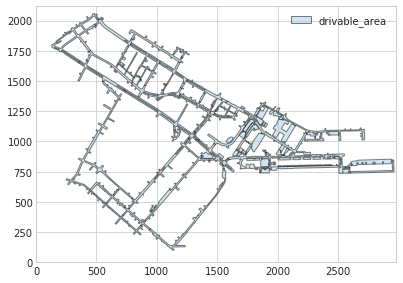

In [9]:
nusc_map = NuscenesMap(dataroot='./data', map_name='boston-seaport')
fig, ax = nusc_map.render_layers(['drivable_area'], figsize=(5, 5))

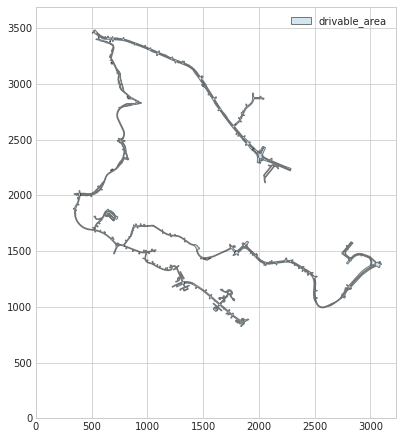

In [10]:
nusc_map = NuscenesMap(dataroot='./data', map_name='singapore-queenstown')
fig, ax = nusc_map.render_layers(['drivable_area'], figsize=(5, 5))

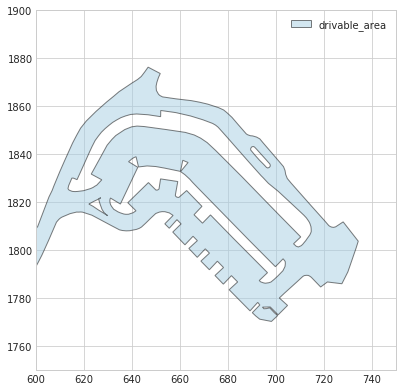

In [11]:
ax.set_xlim(600, 750)
ax.set_ylim(1750, 1900)
ax.set_aspect('equal')
fig

[{'polygon_tokens': ['2c80ba49-5938-42a2-ab7f-8dc2bed2bb57', '78603445-3364-46f8-9e02-88fd23f9aaa6', '02f40707-7b6d-4f21-8cd0-5696d8568106', '12e11297-7f8a-4cfd-8237-9f0f65e94f15', '239576af-8482-45f9-9ff2-b777a388f8e8', 'ef230c33-a9f6-4464-9e47-cacc532d130d', '96afaaec-756d-4de9-b85b-16992d682c46', '51085e09-345a-43c0-9318-769fae18f5c4', '10838d1a-a674-4b11-bd10-f4cdc3f223df', '4b36405e-5fdb-4b36-8db6-83d4f2620f22', 'a1cde840-58fc-40b6-8d7b-de7a6f353468', '3b770bcc-f559-47dc-b96f-051c407770de', 'a56d6472-3bac-4f97-82b1-8970ca9fe9a5'], 'token': '5f4652a4-3ce4-429b-a7e9-3e329f53a0fb'}]


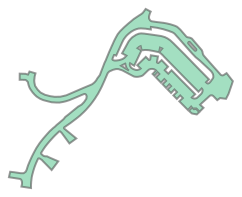

In [12]:
print(nusc_map.drivable_area)
poly = nusc_map.extract_polygon('2c80ba49-5938-42a2-ab7f-8dc2bed2bb57')
poly

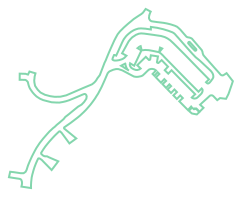

In [13]:
poly.boundary

In [45]:
nusc_map.non_geometric_layers

['drivable_area',
 'road_segment',
 'road_block',
 'lane',
 'ped_crossing',
 'walkway',
 'stop_line',
 'carpark_area',
 'road_divider',
 'lane_divider',
 'traffic_light']

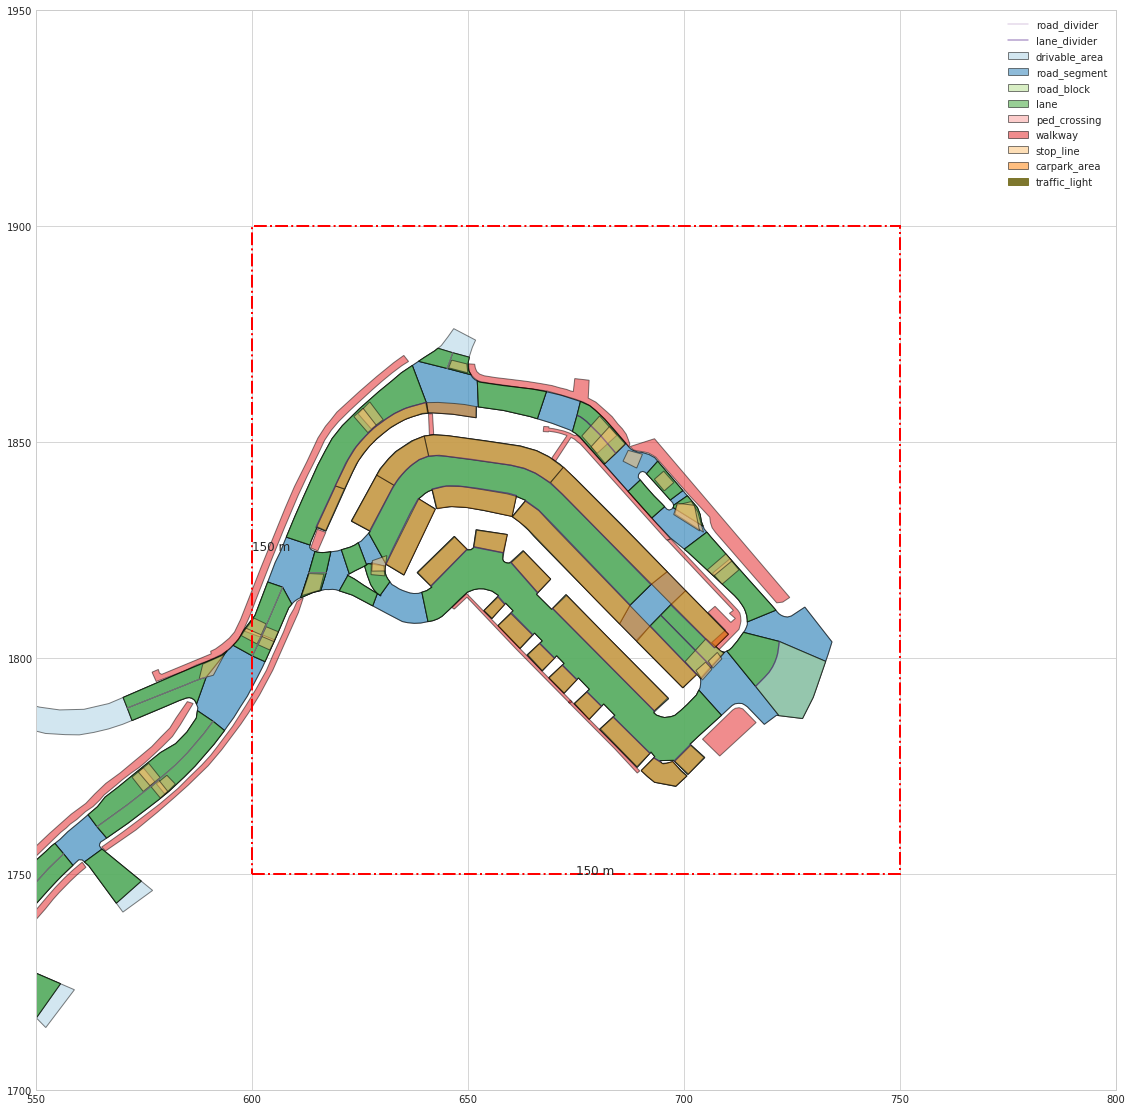

In [55]:
patch = (600, 1750, 750, 1900)
fig, ax = nusc_map.render_map_patch(patch, 
                                    #['road_segment'])
                                    nusc_map.non_geometric_layers)

In [18]:
# fig, ax = nusc_map.render_record('road_segment', 
#                                  nusc_map.road_segment[600]['token'], 
#                                  other_layers=[])

In [20]:
records = nusc_map.explorer.get_records_in_patch(patch, mode='within')
records.keys()

dict_keys(['stop_line', 'walkway', 'road_segment', 'drivable_area', 'road_divider', 'lane_divider', 'road_block', 'lane', 'carpark_area', 'traffic_light', 'ped_crossing'])

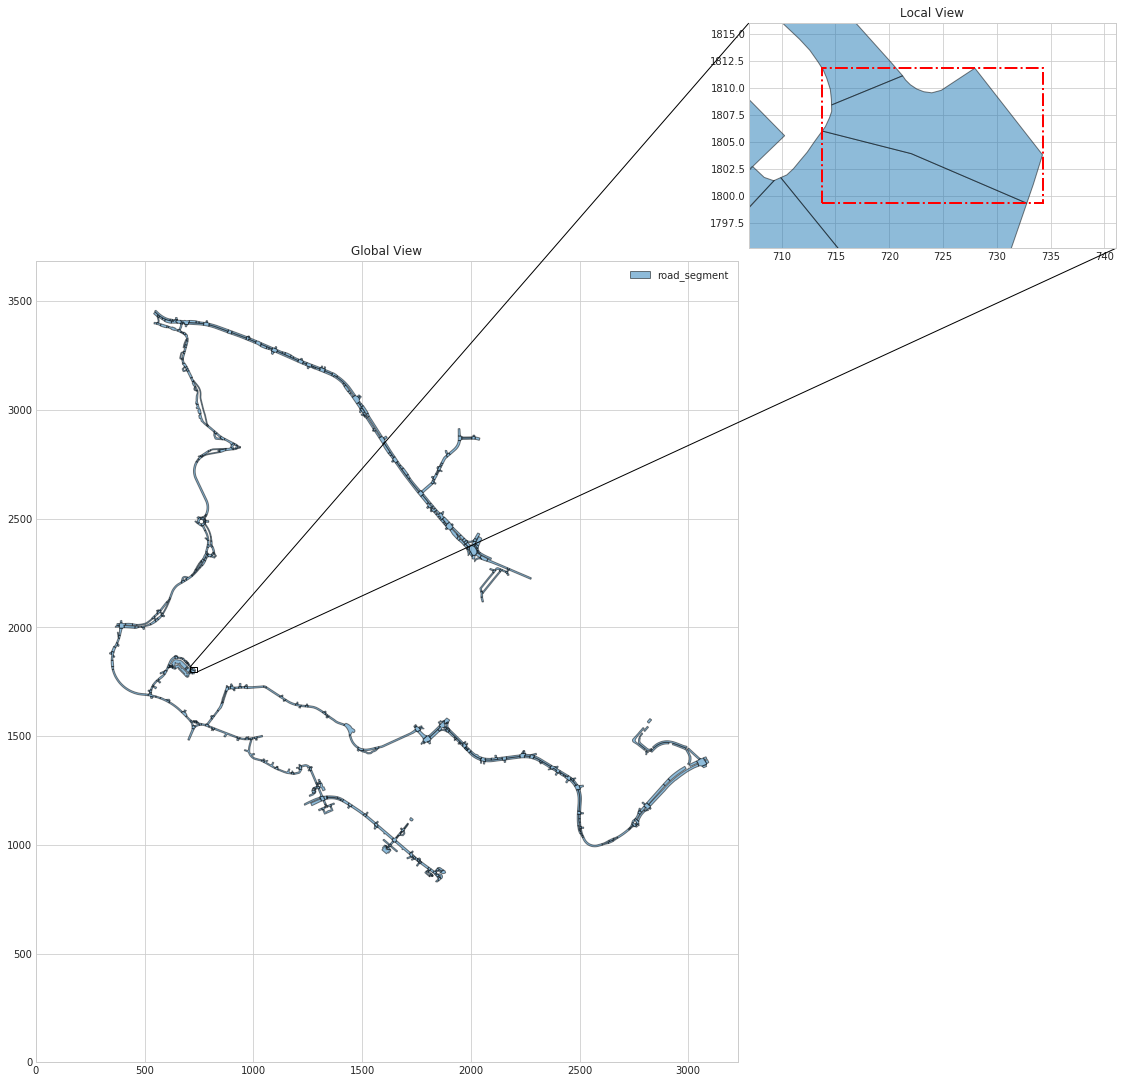

In [61]:
# scene-0916 start:  road_segment e07f59fc-f027-4db0-ac13-c8fbd2423cc5
# end: a4903e8e-36a2-49b5-b236-ef3a254193f8
fig, ax = nusc_map.render_record('road_segment', 'e07f59fc-f027-4db0-ac13-c8fbd2423cc5', other_layers=[])

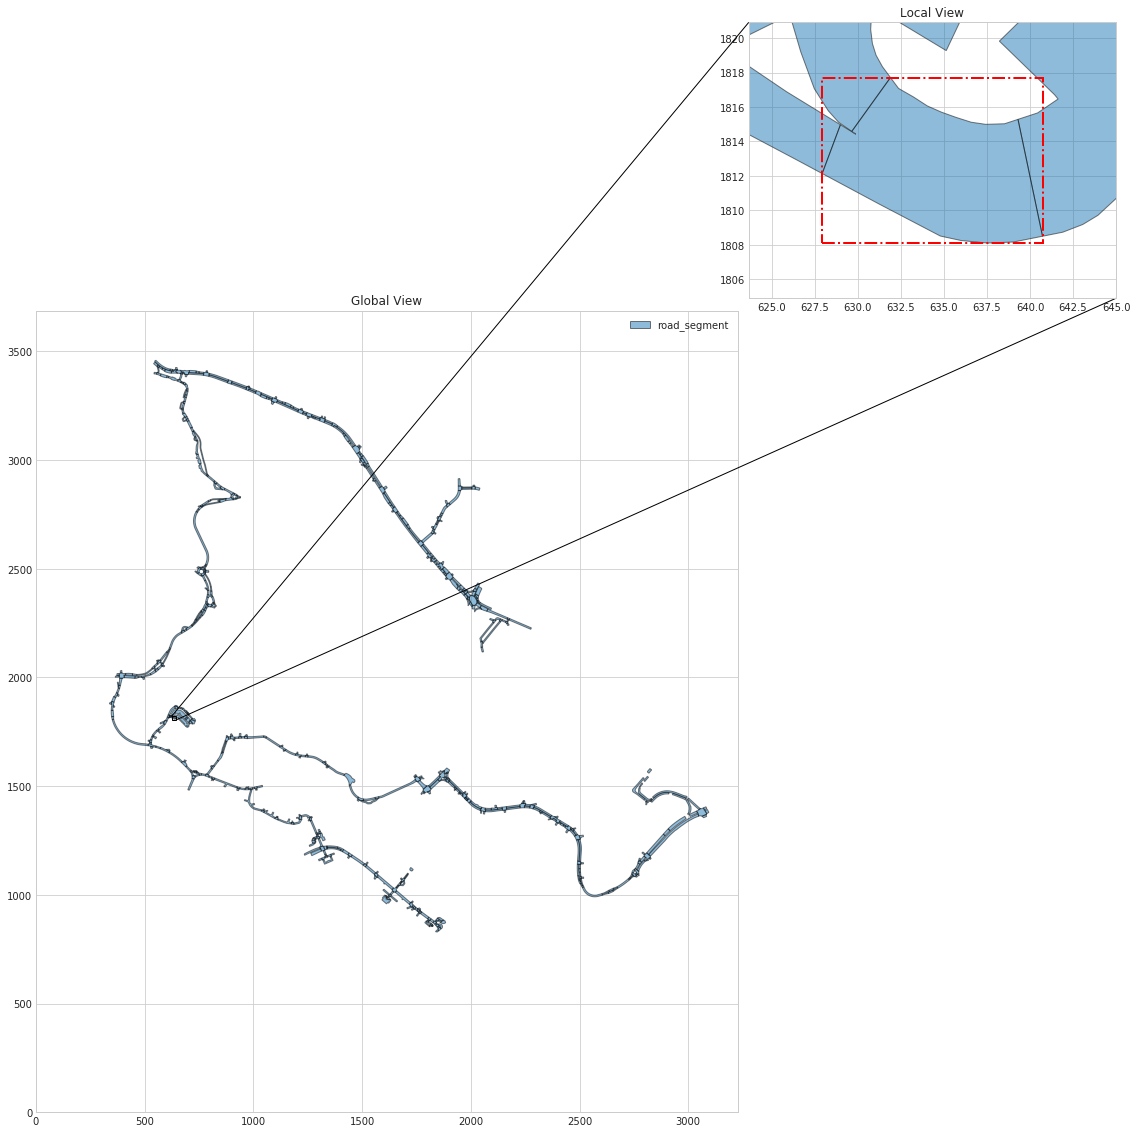

In [62]:
fig, ax = nusc_map.render_record('road_segment', 'a4903e8e-36a2-49b5-b236-ef3a254193f8', other_layers=[])

In [60]:
# for i in records['road_segment']:
#     print(i)
#     fig, ax = nusc_map.render_record('road_segment', i, other_layers=[])
#     plt.show()

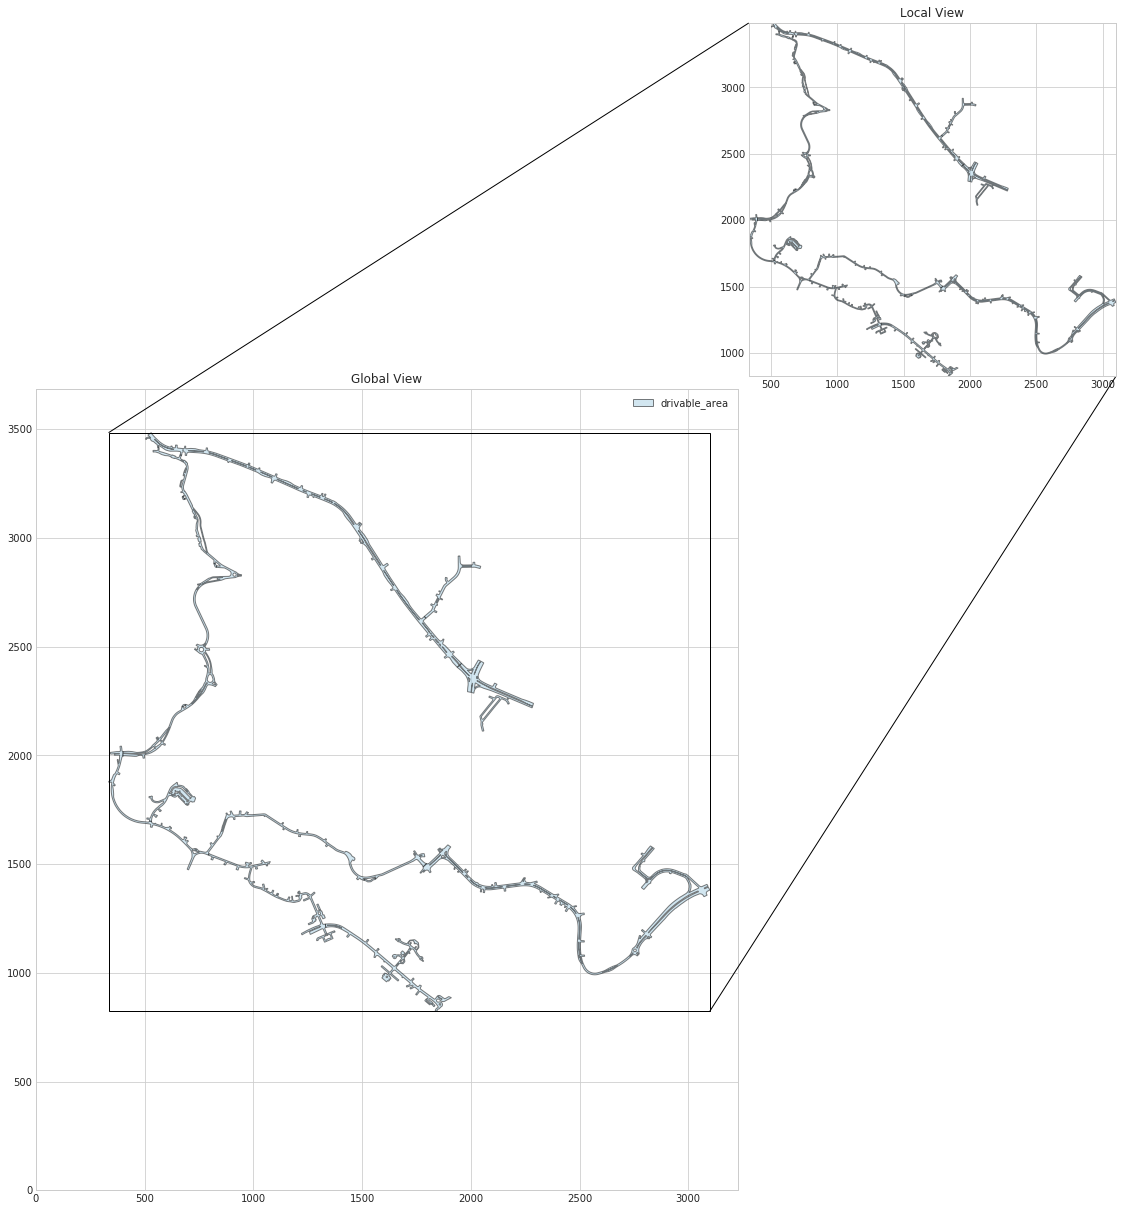

In [114]:
fig, ax = nusc_map.render_record('drivable_area', 
                                '5f4652a4-3ce4-429b-a7e9-3e329f53a0fb',
                                other_layers=[])